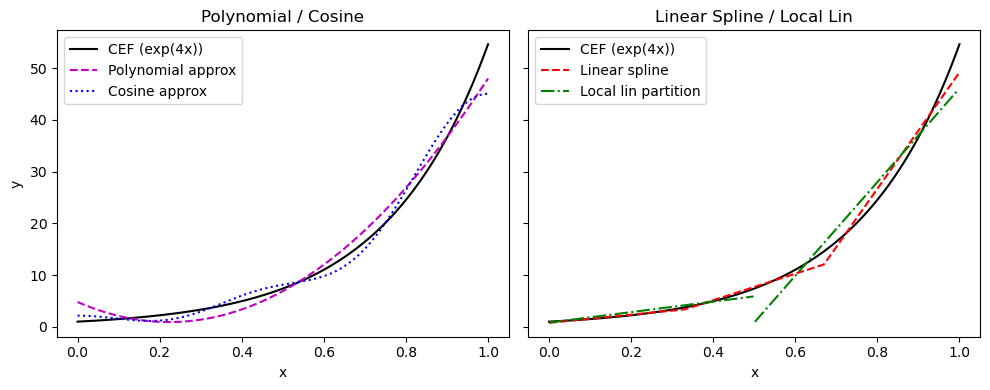

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

np.random.seed(123)
N = 10000000
X = np.random.rand(N, 1)
y = np.exp(4 * X).ravel()

x_grid = np.linspace(0, 1, 300).reshape(-1, 1)
true_cef = np.exp(4 * x_grid).ravel()

def polynomial_features(x, degree=5):
    return np.hstack([x**d for d in range(degree + 1)])

def cosine_features(x, num_terms=5):
    features = [np.ones_like(x)]
    for k in range(1, num_terms + 1):
        features.append(np.cos(k * np.pi * x))
    return np.hstack(features)

def linear_spline_features(x, knots=[0.33, 0.67]):
    x = x.ravel()
    features = [np.ones_like(x), x]
    for knot in knots:
        features.append(np.clip(x - knot, 0, None))
    return np.column_stack(features)

def local_linear_partition_features(x, partitions=[0.5, 1.0]):
    x = x.ravel()
    feat_list = [np.ones_like(x)]
    intervals = [(0.0, partitions[0]), (partitions[0], partitions[1])]
    
    for (left, right) in intervals:
        local_x = np.where((x >= left) & (x < right), x - left, 0.0)
        feat_list.append(local_x)
    
    return np.column_stack(feat_list)

poly_degree = 2
cos_terms = 4
spline_knots = [0.33, 0.67]
partition_points = [0.5, 1.0]

X_poly = polynomial_features(X, degree=poly_degree)
model_poly = LinearRegression(fit_intercept=False).fit(X_poly, y)
X_poly_grid = polynomial_features(x_grid, degree=poly_degree)
y_poly_pred = model_poly.predict(X_poly_grid)

X_cos = cosine_features(X, num_terms=cos_terms)
model_cos = LinearRegression(fit_intercept=False).fit(X_cos, y)
X_cos_grid = cosine_features(x_grid, num_terms=cos_terms)
y_cos_pred = model_cos.predict(X_cos_grid)

X_spline = linear_spline_features(X, knots=spline_knots)
model_spline = LinearRegression(fit_intercept=False).fit(X_spline, y)
X_spline_grid = linear_spline_features(x_grid, knots=spline_knots)
y_spline_pred = model_spline.predict(X_spline_grid)

X_loclin = local_linear_partition_features(X, partitions=partition_points)
model_loclin = LinearRegression(fit_intercept=False).fit(X_loclin, y)
X_loclin_grid = local_linear_partition_features(x_grid, partitions=partition_points)
y_loclin_pred = model_loclin.predict(X_loclin_grid)


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax_left = axes[0]
ax_left.plot(x_grid, true_cef, 'k-', label='CEF (exp(4x))')
ax_left.plot(x_grid, y_poly_pred, 'm--', label='Polynomial approx')
ax_left.plot(x_grid, y_cos_pred, 'b:', label='Cosine approx')
ax_left.set_xlabel('x')
ax_left.set_ylabel('y')
ax_left.set_title('Polynomial / Cosine')
ax_left.legend()

ax_right = axes[1]
ax_right.plot(x_grid, true_cef, 'k-', label='CEF (exp(4x))')
ax_right.plot(x_grid, y_spline_pred, 'r--', label='Linear spline')

# Plot local linear in segments
mask1 = (x_grid < partition_points[0]).ravel()
mask2 = ((x_grid >= partition_points[0]) & (x_grid < partition_points[1])).ravel()
ax_right.plot(x_grid[mask1], y_loclin_pred[mask1], 'g-.', label='Local lin partition')
ax_right.plot(x_grid[mask2], y_loclin_pred[mask2], 'g-.')

ax_right.set_xlabel('x')
ax_right.set_title('Linear Spline / Local Lin')
ax_right.legend()

plt.tight_layout()
plt.savefig('function_approximation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
